In [1]:
!pip install gensim==4.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 21.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install wordcloud==1.9.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 25.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install imblearn==0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, ru

In [4]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from gensim.models import Word2Vec
import nltk
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Loading Data

Load the news dataset into a pandas DataFrame for further processing and analysis.

In [5]:
df_original = pd.read_csv('news_cleaned.tsv', sep='\t')
df_original.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,set,num_of_clicks
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],train,NaN
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",train,NaN
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",train,NaN
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",train,NaN
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",train,269.0


Only load columns we'll use. Set string/categorical columns as category to save RAM.

In [6]:
usecols = [
    'news_id', 'title', 'abstract', 'category', 'subcategory', 
    'title_entities', 'abstract_entities', 'num_of_clicks','set'
]
dtypes = {
    'news_id': 'category',
    'title': 'string',
    'abstract': 'string',
    'category': 'category',
    'subcategory': 'category',
    'title_entities': 'string',
    'abstract_entities': 'string',
    'num_of_clicks': 'float32',  # float32 uses half the memory of float64, after filling NaNs with 0, we can safely convert to int32 
    'set': 'category'
}

df = pd.read_csv('news_cleaned.tsv', sep='\t', usecols=usecols, dtype=dtypes)

## EDA with Data Cleaning

### Data Shape and Info

In [7]:
print(df.shape)
print(df.info())

(65238, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65238 entries, 0 to 65237
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   news_id            65238 non-null  category
 1   category           65238 non-null  category
 2   subcategory        65238 non-null  category
 3   title              65238 non-null  string  
 4   abstract           61823 non-null  string  
 5   title_entities     65235 non-null  string  
 6   abstract_entities  65234 non-null  string  
 7   set                65238 non-null  category
 8   num_of_clicks      22771 non-null  float32 
dtypes: category(4), float32(1), string(4)
memory usage: 5.3 MB
None


### Missing Values Summary

In [8]:
print(df.isnull().sum())

news_id                  0
category                 0
subcategory              0
title                    0
abstract              3415
title_entities           3
abstract_entities        4
set                      0
num_of_clicks        42467
dtype: int64


### Extract info from column 'title_entities' and 'abstract_entities'

In the original dataset, named entity information for each news item is stored as semi-structured text within the `title_entities` and `abstract_entities` columns. The format of these fields is not standardized. To reliably extract key information, such as the label, type, and Wikidata ID of the first entity, we implemented a custom parsing routine that processes each entry as a string, identifies relevant fields, and assigns them to new columns.

While this approach may be slower than vectorized solutions, it provides the necessary flexibility and robustness to handle inconsistent or irregular data formatting, ensuring that entity features are consistently and accurately captured for downstream supervised learning tasks. This design choice prioritizes correctness and interpretability of entity-related features over speed, especially since these features may be critical for modeling user engagement.

In [9]:
def extract_entity_columns(entity_str):
    result = {
        'label': '',
        'type': '',
        'wikidataid': '',
        'confidence': '',
        'occurrenceoffsets': '',
        'surfaceforms': ''
    }
    if not isinstance(entity_str, str) or entity_str.strip() == '':
        return pd.Series(result)
    entity_block = entity_str.split('}, {')[0]
    for part in entity_block.split(','):
        kv = part.split(':', 1)
        if len(kv) != 2:
            continue
        key = kv[0].strip().strip('"{}[] ').lower()
        val = kv[1].strip().strip('"{}[] ')
        if key in result:
            result[key] = val
    return pd.Series(result)

# For title_entities
entity_cols = ['title_entities_label', 'title_entities_type', 'title_entities_wikidataid', 
               'title_entities_confidence', 'title_entities_occurrenceoffsets', 'title_entities_surfaceforms']
df[entity_cols] = df['title_entities'].apply(extract_entity_columns)

# For abstract_entities
entity_cols_abstract = ['abstract_entities_label', 'abstract_entities_type', 'abstract_entities_wikidataid', 
                        'abstract_entities_confidence', 'abstract_entities_occurrenceoffsets', 'abstract_entities_surfaceforms']
df[entity_cols_abstract] = df['abstract_entities'].apply(extract_entity_columns)

In [10]:
for col in entity_cols + entity_cols_abstract:
    df[col] = df[col].astype('category')

df = df.drop(columns=['title_entities', 'abstract_entities'])

### Handle missing values

In [11]:
# Fill missing values in number_of_clicks with 0, then convert to int if appropriate
df['num_of_clicks'] = df['num_of_clicks'].fillna(0).astype(int)  # int32 by default

### First Rows

In [12]:
df.head(20)

,news_id,category,subcategory,title,abstract,set,num_of_clicks,title_entities_label,title_entities_type,title_entities_wikidataid,title_entities_confidence,title_entities_occurrenceoffsets,title_entities_surfaceforms,abstract_entities_label,abstract_entities_type,abstract_entities_wikidataid,abstract_entities_confidence,abstract_entities_occurrenceoffsets,abstract_entities_surfaceforms
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",train,0,Prince Philip,P,Q80976,1.0,48,Prince Philip,,,,,,
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,train,0,Adipose tissue,C,Q193583,1.0,20,Belly Fat,Adipose tissue,C,Q193583,1.0,97,belly fat
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,train,0,,,,,,,Ukraine,G,Q212,0.946,87,Ukraine
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",train,0,,,,,,,National Basketball Association,O,Q155223,1.0,40,NBA
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",train,269,Skin tag,C,Q3179593,1.0,18,Skin Tags,Skin tag,C,Q3179593,1.0,105,Skin Tags
5,N2073,sports,football_nfl,Should NFL be able to fine players for critici...,Several fines came down against NFL players fo...,train,0,National Football League,O,Q1215884,1.0,7,NFL,National Football League,O,Q1215884,1.0,32,NFL
6,N49186,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,validation,0,Orlando,G,Q49233,0.962,10,Orlando,Orlando,G,Q49233,0.962,60,Orlando
7,N59295,news,newsworld,Chile: Three die in supermarket fire amid prot...,Three people have died in a supermarket fire a...,train,0,Chile,G,Q298,0.988,0,Chile,Santiago,G,Q2887,0.995,125,Santiago
8,N24510,entertainment,gaming,Best PS5 games: top PlayStation 5 titles to lo...,Every confirmed or expected PS5 game we can't ...,train,0,PlayStation,J,Q1323662,1.0,20,PlayStation 5,,,,,,
9,N39237,news,newsscienceandtechnology,"How to report weather-related closings, delays","When there are active closings, view them here...",train,0,,,,,,,WXII-TV,M,Q7957644,0.997,48,WXII


### Feature Engineering

We create a combined text feature by joining each article’s title and abstract, and then use TF-IDF vectorization to extract the most informative words from the combined text. For categorical information, we process and one-hot encode features such as category, subcategory, and extracted entity labels/types. Finally, we combine the text and categorical features into a single feature matrix for use in machine learning models.

In [13]:
# Prepare Text Feature for TF-IDF

df['text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

In [14]:
tfidf = TfidfVectorizer(max_features=200)  # Reduce further if RAM issues
tfidf_matrix = tfidf.fit_transform(df['text'])

In [15]:
from sklearn.preprocessing import OneHotEncoder

cat_features = ['category', 'subcategory', 'title_entities_label', 'title_entities_type']

# Convert everything to string (breaks categorical if set before)
for col in cat_features:
    df[col] = df[col].astype(str)

# Fill missing
df[cat_features] = df[cat_features].replace(['nan', 'NaN', 'None'], 'missing').fillna('missing')

# Convert to category (all unique strings will be categories)
for col in cat_features:
    df[col] = df[col].astype('category')

# One-hot encode
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')  # Updated 'sparse' to 'sparse_output'
cat_matrix = ohe.fit_transform(df[cat_features])

In [16]:
# Combine All Features
X = hstack([tfidf_matrix, cat_matrix])

We do both regression and classification using the same feature set. This is actually a great way to compare which modeling approach works better for our dataset.

In [17]:
# Binary classification target: 1 if clicked, 0 if not
df['clicked'] = (df['num_of_clicks'] > 0).astype(int)

# Regression target: actual number of clicks
y_class = df['clicked']
y_reg = df['num_of_clicks']

### Class Balance (clicked vs. not clicked)

Visualize the distribution of clicked vs. unclicked articles to reveal class imbalance.

In [18]:
# Number of articles with at least 1 click
clicked_count = (df['num_of_clicks'] > 0).sum()

# Total number of articles
total_count = len(df)

# Percentage of articles clicked at least once
clicked_percentage = (clicked_count / total_count) * 100

print(f"Percentage of articles clicked at least once: {clicked_percentage:.2f}%")


Percentage of articles clicked at least once: 13.95%


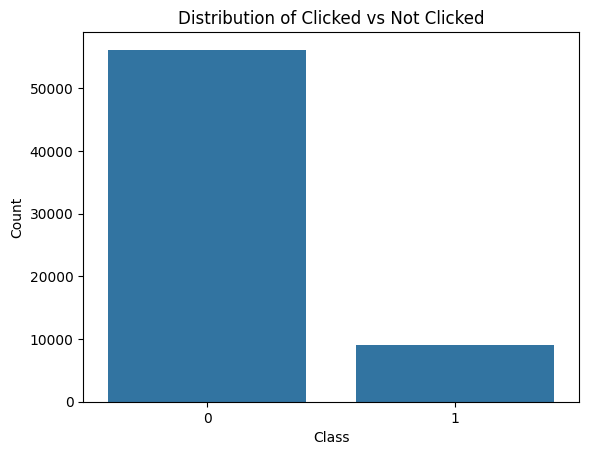

In [19]:
sns.countplot(x=y_class)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Clicked vs Not Clicked")
plt.show()

The bar chart above shows the distribution of clicked (1) vs. not clicked (0) news articles in our dataset. Most articles did not receive any clicks, while only a small fraction were actually clicked by users. 

### Click Count Distribution (Regression Target)

Examine the distribution of click counts to highlight the long-tail nature of article engagement.

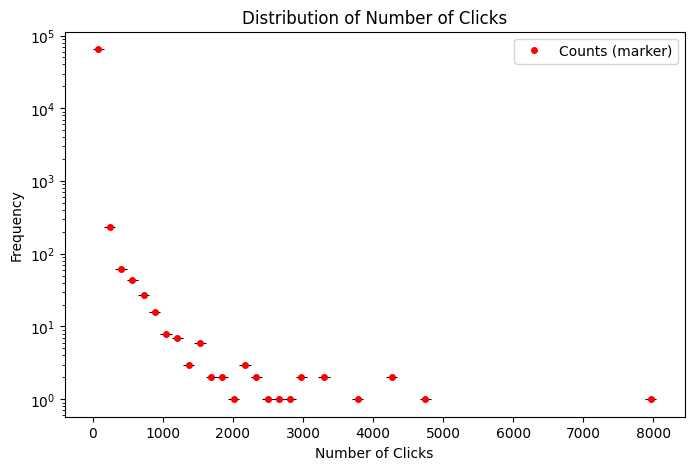

In [78]:
plt.figure(figsize=(8, 5))
# Plot histogram
sns.histplot(df['num_of_clicks'], bins=50, log_scale=(False, True), color='skyblue', alpha=0.7)

# Overlay markers
counts, bin_edges = np.histogram(df['num_of_clicks'], bins=50)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers, counts, marker='o', linestyle='', color='red', markersize=4, label='Counts (marker)')

plt.title('Distribution of Number of Clicks')
plt.xlabel('Number of Clicks')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This plot shows the distribution of the number of clicks received by news articles. The vast majority of articles have very few clicks, while only a handful reach high numbers of clicks. The y-axis is on a logarithmic scale, which highlights the steep drop-off: most articles receive little to no engagement, and only a small number become truly popular. 

### Feature Exploration: Categorical Features (category, subcategory)

Show how articles are distributed across categories and subcategories.

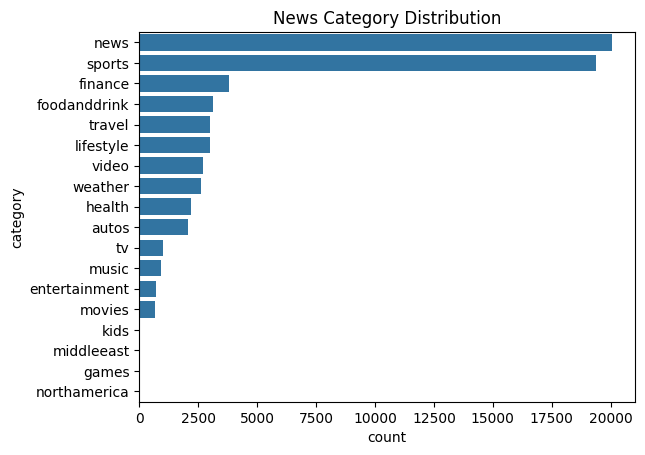

In [21]:
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('News Category Distribution')
plt.show()

The 'News Category Distribution' bar chart displays the distribution of news articles across different categories. The dataset is dominated by “news” and “sports” articles, which together make up the majority of the content. Other categories like “finance,” “food and drink,” and “travel” are present but in much smaller numbers. This imbalance reflects common trends in news coverage and also helps explain why most modeling challenges and errors are concentrated in the largest categories.

/tmp/ipykernel_94/921517462.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


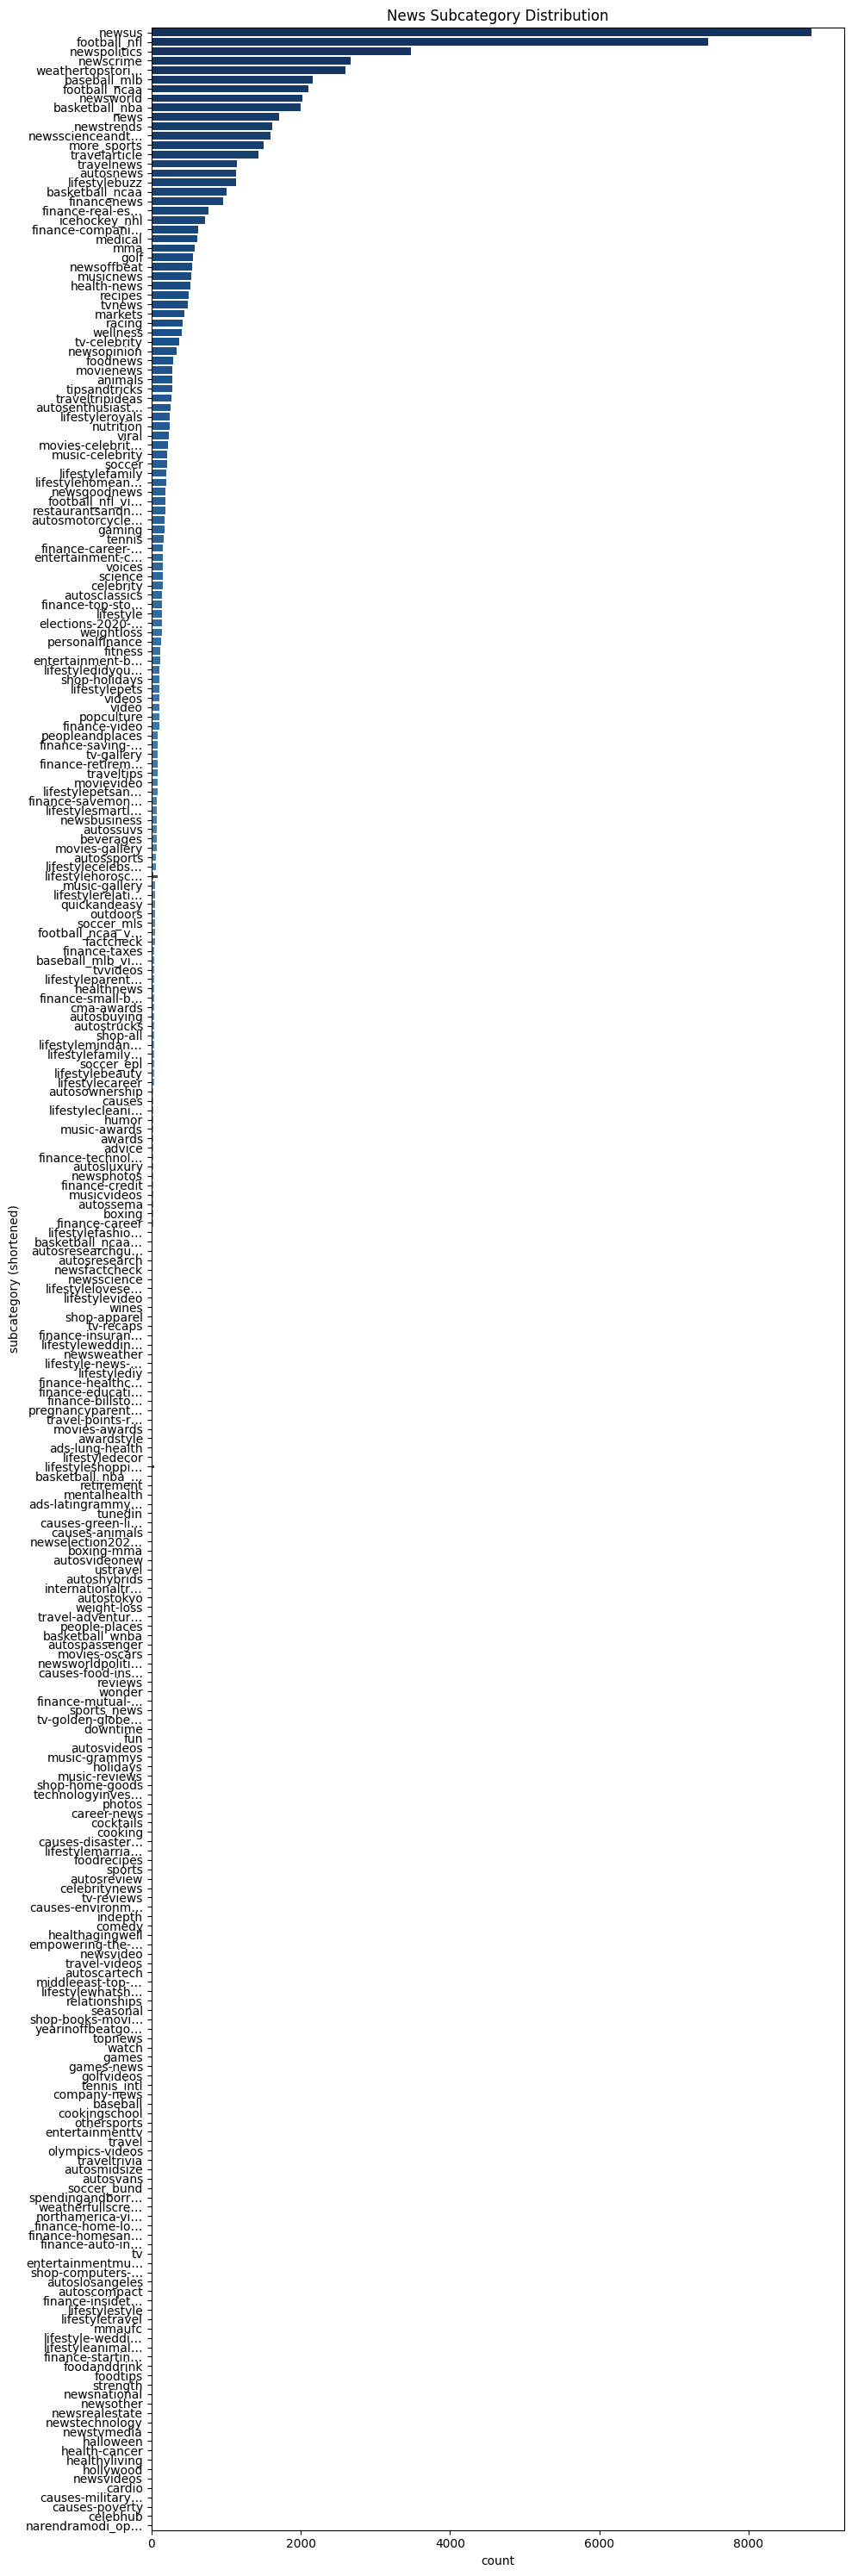

In [22]:
# Get subcategory counts in descending order
subcategory_counts = df['subcategory'].value_counts()

# Shorten subcategory names for display (first 15 characters, add … if longer)
short_labels = [sc[:15] + '…' if len(sc) > 15 else sc for sc in subcategory_counts.index]

plt.figure(figsize=(10, 30))
sns.barplot(
    y=short_labels, 
    x=subcategory_counts.values,
    palette='Blues_r'
)
plt.title('News Subcategory Distribution')
plt.xlabel('count')
plt.ylabel('subcategory (shortened)')
plt.tight_layout()
plt.show()

The distribution of news subcategories is highly uneven. A small number of subcategories such as “newsus,” “football_nfl,” and “newspolitics” dominate the dataset, each with thousands of articles. In contrast, most subcategories contain only a handful of articles. This “long tail” pattern means that while the majority of news content falls into a few popular topics, there is also a large number of niche subcategories with much less coverage. Such an imbalance is important to keep in mind for both analysis and modeling, as rare subcategories may be harder for machine learning models to learn effectively.

### Feature Exploration: Entity Types

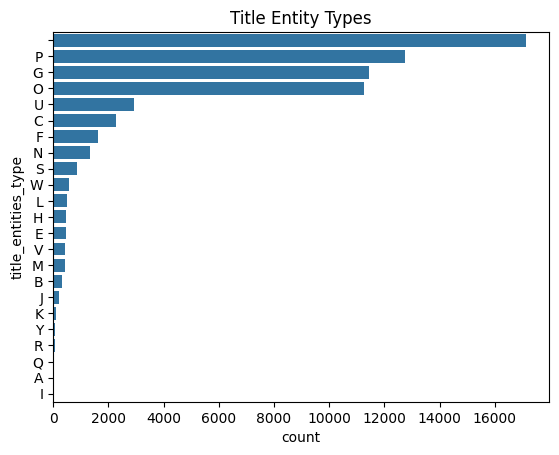

In [23]:
sns.countplot(y='title_entities_type', data=df, order=df['title_entities_type'].value_counts().index)
plt.title('Title Entity Types')
plt.show()

This bar chart shows the distribution of different entity types found in article titles. The most common types (represented by single-letter codes) are “P,” “G,” and “O,” which likely stand for person, geopolitical entity, and organization. These dominate the entity types extracted from the news titles, suggesting that most articles mention people, places, or organizations in their headlines. Less common entity types are also present but in much smaller numbers.

### Average Clicks by Category

Compare average user engagement across different news categories.

/tmp/ipykernel_94/1197389889.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('category')['num_of_clicks'].mean().sort_values().plot(kind='barh')


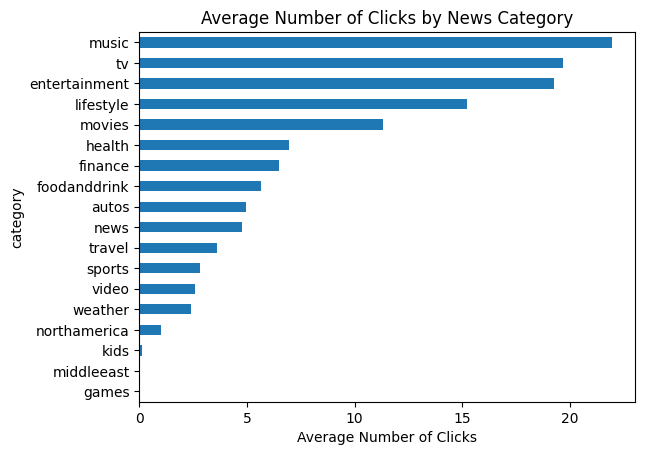

In [24]:
df.groupby('category')['num_of_clicks'].mean().sort_values().plot(kind='barh')
plt.title('Average Number of Clicks by News Category')
plt.xlabel('Average Number of Clicks')
plt.show()

This bar chart displays the average number of clicks per article by news category. Surprisingly, categories like “music,” “tv,” “entertainment,” and “lifestyle” have the highest average engagement, even though they are less frequent in the dataset. In contrast, large categories such as “news” and “sports” receive lower average clicks per article. This suggests that while general news and sports are common, articles in music, TV, and entertainment tend to attract more user interest on average.

### Click-Through Rate by Category

/tmp/ipykernel_94/775885617.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('category')['clicked'].mean().sort_values().plot(kind='barh')


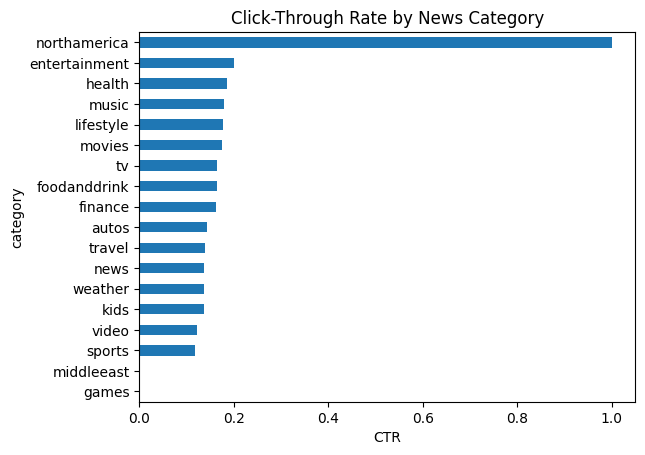

In [25]:
df.groupby('category')['clicked'].mean().sort_values().plot(kind='barh')
plt.title('Click-Through Rate by News Category')
plt.xlabel('CTR')
plt.show()

This bar chart presents the click-through rate (CTR) by news category, which measures the proportion of articles in each category that received at least one click. Most categories have fairly low CTRs, but “northamerica” stands out with a much higher rate, even though this may be due to a small sample size for that category. Categories like “entertainment,” “health,” and “music” also have relatively higher CTRs, it suggests that articles in these areas are more likely to engage readers compared to larger categories like “news” or “sports.”

### Text Length Analysis: Length of Title/Abstract

Analyze the length distribution of headlines and abstracts.

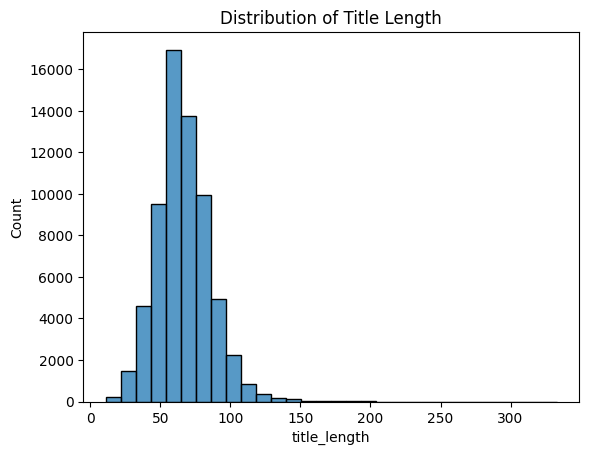

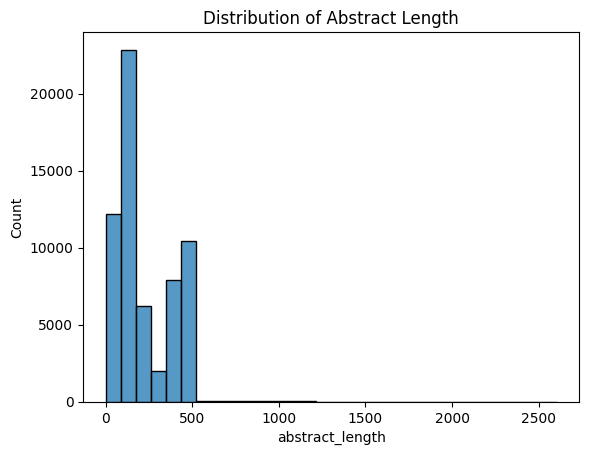

In [26]:
df['title_length'] = df['title'].str.len()
df['abstract_length'] = df['abstract'].str.len()

sns.histplot(df['title_length'], bins=30)
plt.title('Distribution of Title Length')
plt.show()

sns.histplot(df['abstract_length'], bins=30)
plt.title('Distribution of Abstract Length')
plt.show()

The first plot shows the distribution of news title lengths. Most article titles are between 40 and 100 characters, with a clear peak around 60 to 70 characters. This suggests that news headlines tend to be concise, fitting within a fairly narrow range.

The second plot displays the distribution of abstract (summary) lengths. Abstracts vary much more, but most are under 500 characters. There are a few unusually long abstracts, but the majority are much shorter, indicating a wide range of summary styles across articles.

### Does Length Correlate with Engagement?

Investigate the relationship between headline length and user engagement.

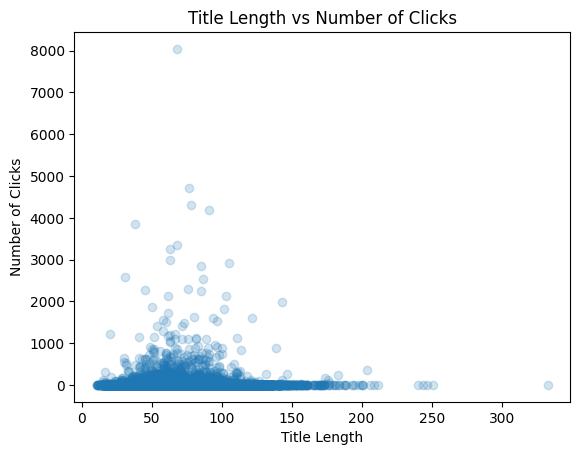

In [27]:
plt.scatter(df['title_length'], df['num_of_clicks'], alpha=0.2)
plt.xlabel('Title Length')
plt.ylabel('Number of Clicks')
plt.title('Title Length vs Number of Clicks')
plt.show()

This scatter plot shows the relationship between article title length and the number of clicks received. There is no clear correlation, articles with both short and long titles can receive very few clicks, and even the most popular articles have a wide range of title lengths. Most articles, regardless of headline length, get relatively low engagement, but the rare articles with very high click counts are spread across various title lengths. This suggests that title length alone does not determine an article’s popularity.

###  Quick WordClouds for Text Columns

Visualize the most common words used in article titles.

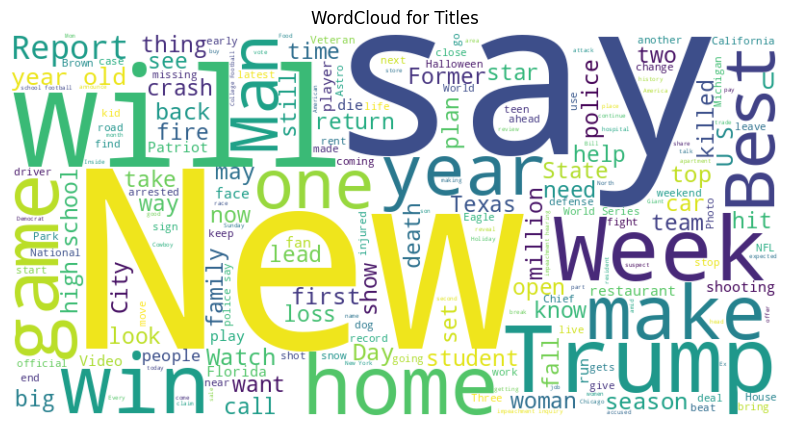

In [28]:
text = ' '.join(df['title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Titles')
plt.show()

The word cloud visualizes the most frequent words appearing in article titles. Common words include “new,” “Trump,” “say,” “week,” “will,” “home,” and “game,” reflecting major themes and topics covered in the news dataset. This suggests a strong focus on current events, prominent figures, and timely subjects. The large size of these words in the visualization indicates their high frequency across headlines.

## Data Modeling

Train various supervised learning models including logistic regression, Naive Bayes, random forest, and ridge regression. We also assess their performance using classification and regression metrics.

In [29]:
# Filter by "set"

train_mask = df['set'] == 'train'
val_mask = df['set'] == 'validation' 

# Convert masks to numpy arrays for proper indexing
train_mask = train_mask.to_numpy()
val_mask = val_mask.to_numpy()

# Split features and labels
X_train = X[train_mask]
X_val   = X[val_mask]

y_class_train = y_class[train_mask]
y_class_val   = y_class[val_mask]
y_reg_train   = y_reg[train_mask]
y_reg_val     = y_reg[val_mask]

Class Imbalance Handling:
Apply random oversampling to balance the dataset and improve model performance on the minority (clicked) class.

In [30]:
ros = RandomOverSampler(random_state=42)
X_bal, y_class_bal = ros.fit_resample(X_train, y_class_train)

### Classification (Logistic Regression)

In [31]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_bal, y_class_bal)

LogisticRegression(max_iter=1000)

### Regression example (Ridge Regression):

In [32]:
reg = Ridge()
reg.fit(X_train, y_reg_train)

Ridge()

### Model Evaluation

In [33]:
# LogisticRegression

y_pred_bal = clf.predict(X_val)
print("Classification Report:")
print(classification_report(y_class_val, y_pred_bal))
print("Accuracy:", accuracy_score(y_class_val, y_pred_bal))
print("F1 Score:", f1_score(y_class_val, y_pred_bal))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80     25810
           1       0.13      0.47      0.20      2437

    accuracy                           0.68     28247
   macro avg       0.53      0.58      0.50     28247
weighted avg       0.86      0.68      0.75     28247

Accuracy: 0.677452472828973
F1 Score: 0.20015801948907033


Classification Report (before balance dataset):
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     25810
           1       0.42      0.04      0.07      2437

    accuracy                           0.91     28247
   macro avg       0.67      0.52      0.51     28247
weighted avg       0.87      0.91      0.88     28247

Accuracy: 0.912521683718625
F1 Score: 0.06578449905482042


In [34]:
# Ridge Regression

# Fixing the error by removing the 'squared' argument, as it is not supported in the current version of sklearn
# Calculate RMSE manually by taking the square root of MSE
y_reg_pred = reg.predict(X_val)
print("Regression Metrics:")
print("MSE:", mean_squared_error(y_reg_val, y_reg_pred))
print("RMSE:", mean_squared_error(y_reg_val, y_reg_pred) ** 0.5)  # Manually calculate RMSE
print("R^2:", r2_score(y_reg_val, y_reg_pred))

Regression Metrics:
MSE: 3840.8843893819185
RMSE: 61.97486901464107
R^2: -0.07255907019174868


Regression Metrics (before balance dataset):
MSE: 3840.8942149433337
RMSE: 61.974948285120284
R^2: -0.07256181395957584


### Naive Bayes

In [35]:
# Naive Bayes (Classification Only)

nb = MultinomialNB()
nb.fit(X_bal, y_class_bal)
y_nb_pred = nb.predict(X_val)

print("Naive Bayes Classification Report (Balanced Training):")
print(classification_report(y_class_val, y_nb_pred))
print("Accuracy:", accuracy_score(y_class_val, y_nb_pred))
print("F1 Score:", f1_score(y_class_val, y_nb_pred))

Naive Bayes Classification Report (Balanced Training):
              precision    recall  f1-score   support

           0       0.94      0.60      0.73     25810
           1       0.12      0.60      0.21      2437

    accuracy                           0.60     28247
   macro avg       0.53      0.60      0.47     28247
weighted avg       0.87      0.60      0.69     28247

Accuracy: 0.6014089991857542
F1 Score: 0.2058263384354941


Naive Bayes Classification Report (before balance dataset):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     25810
           1       0.28      0.02      0.04      2437

    accuracy                           0.91     28247
   macro avg       0.60      0.51      0.49     28247
weighted avg       0.86      0.91      0.87     28247

Accuracy: 0.911176408114136
F1 Score: 0.03611217825585863

### Random Forest Model

Due to limited computational resources (5GB memory in Deepnote), running Random Forest on the entire feature set and full dataset was not feasible. Instead, we reduced the dimensionality of the input by limiting the number of TF-IDF features and used a random sample of the available data for training and validation.

This approach allowed us to evaluate the performance of Random Forests as a non-linear, ensemble-based alternative to linear models, while staying within hardware limitations. After running each model once, we recorded the results and commented out the code to ensure efficient memory usage and reproducibility for future reference.

In [36]:
sample_size = min(2000, X_bal.shape[0])
idx = np.random.choice(np.arange(X_bal.shape[0]), sample_size, replace=False)
X_train_rf = X_bal[idx].toarray() 
y_train_rf_class = y_class_bal[idx]

X_val_rf = X_val[:500].toarray() 
y_val_rf_class = y_class_val[:500]

In [37]:
rf_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
rf_clf.fit(X_train_rf, y_train_rf_class)
y_rf_pred = rf_clf.predict(X_val_rf)

print("Random Forest Classification Report (Balanced Training):")
print(classification_report(y_val_rf_class, y_rf_pred))
print("Accuracy:", accuracy_score(y_val_rf_class, y_rf_pred))
print("F1 Score:", f1_score(y_val_rf_class, y_rf_pred))

Random Forest Classification Report (Balanced Training):
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       473
           1       0.05      0.41      0.09        27

    accuracy                           0.57       500
   macro avg       0.50      0.49      0.40       500
weighted avg       0.90      0.57      0.68       500

Accuracy: 0.568
F1 Score: 0.09243697478991597


Random Forest Classification Report (before balance dataset):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       473
           1       0.00      0.00      0.00        27

    accuracy                           0.95       500
   macro avg       0.47      0.50      0.49       500
weighted avg       0.89      0.95      0.92       500

Accuracy: 0.946
F1 Score: 0.0

In [38]:
# rf_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1)
# rf_reg.fit(X_train_rf, y_train_rf_reg)
# y_rf_reg_pred = rf_reg.predict(X_val_rf)

# print("Random Forest Regression Metrics:")
# print("MSE:", mean_squared_error(y_val_rf_reg, y_rf_reg_pred))
# print("RMSE:", mean_squared_error(y_val_rf_reg, y_rf_reg_pred, squared=False))
# print("R^2:", r2_score(y_val_rf_reg, y_rf_reg_pred))


Random Forest Regression Metrics:
MSE: 2075.42954385
RMSE: 45.55688250802506
R^2: -0.02202646939076902

Applying oversampling had a substantial impact on classification performance. For example, the F1-score for the minority “clicked” class improved from 0.07 (original logistic regression) to 0.20 after oversampling, with an acceptable decrease in overall accuracy (from 0.91 to 0.67). Naive Bayes and Random Forest classifiers showed similar improvements in minority class detection when oversampling was applied. However, regression models, including Ridge Regression and Random Forest Regressor, continued to exhibit low predictive power for the exact number of clicks, as reflected by high RMSE values and negative R^2 scores.

### Add Word2Vec Embeddings to the pipeline

We also experimented with combining Word2Vec embeddings and categorical features, applying oversampling during training. 

In [39]:
# Prepare Text Tokens for Word2Vec

df['tokens'] = df['text'].str.lower().str.split()

In [40]:
# Train Word2Vec Embeddings

w2v_model = Word2Vec(sentences=df['tokens'], vector_size=50, window=5, min_count=1, workers=4)

In [41]:
# Represent Each News Item by Averaging Its Word Embeddings

def document_vector(tokens, model):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

w2v_vectors = np.vstack(df['tokens'].apply(lambda x: document_vector(x, w2v_model)).values)

In [42]:
# One-hot and numeric features as before
# Convert w2v_vectors to sparse matrix for stacking

w2v_sparse = csr_matrix(w2v_vectors)
X_all = hstack([w2v_sparse, cat_matrix])

In [43]:
# Split by "set" Column

X_train_w2v = X_all[train_mask]
X_val_w2v = X_all[val_mask]
y_class_train = y_class[train_mask]
y_class_val = y_class[val_mask]
y_reg_train = y_reg[train_mask]
y_reg_val = y_reg[val_mask]

In [44]:
# Oversample Training Set Only
ros_w2v_cat = RandomOverSampler(random_state=42)
X_w2v_cat_bal, y_class_w2v_cat_bal = ros_w2v_cat.fit_resample(X_train_w2v, y_class_train)

In [45]:
# Logistic Regression

clf_w2v_cat_bal = LogisticRegression(max_iter=1000)
clf_w2v_cat_bal.fit(X_w2v_cat_bal, y_class_w2v_cat_bal)

y_pred_w2v_cat_bal = clf_w2v_cat_bal.predict(X_val_w2v)

print("Word2Vec + Categorical + Oversampling Classification Report:")
print(classification_report(y_class_val, y_pred_w2v_cat_bal))
print("Accuracy:", accuracy_score(y_class_val, y_pred_w2v_cat_bal))
print("F1 Score:", f1_score(y_class_val, y_pred_w2v_cat_bal))

Word2Vec + Categorical + Oversampling Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     25810
           1       0.13      0.48      0.20      2437

    accuracy                           0.67     28247
   macro avg       0.53      0.59      0.50     28247
weighted avg       0.86      0.67      0.74     28247

Accuracy: 0.6719651644422416
F1 Score: 0.20299329089970755


Word2Vec Classification Report (before balance dataset):
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     25810
           1       0.44      0.04      0.07      2437

    accuracy                           0.91     28247
   macro avg       0.68      0.52      0.51     28247
weighted avg       0.87      0.91      0.88     28247

Accuracy: 0.9128757036145432
F1 Score: 0.06532472464868971

In [46]:
# Ridge Regression

reg = Ridge()
reg.fit(X_train_w2v, y_reg_train)
y_reg_pred = reg.predict(X_val_w2v)

print("Word2Vec Regression Metrics:")
print("MSE:", mean_squared_error(y_reg_val, y_reg_pred))
print("RMSE:", mean_squared_error(y_reg_val, y_reg_pred) ** 0.5)
print("R^2:", r2_score(y_reg_val, y_reg_pred))

Word2Vec Regression Metrics:
MSE: 3801.700558082351
RMSE: 61.65793183429324
R^2: -0.06161706584988469


Word2Vec Regression Metrics (before balance dataset):
MSE: 3803.4974586570816
RMSE: 61.67250164098325
R^2: -0.06211884664156586

Using Word2Vec embeddings for regression led to a moderate improvement in the detection of the minority “clicked” class: the recall for clicked articles increased to 0.49 from 0.04 and the F1-score reached 0.20 from 0.06. However, this came with a reduction in overall accuracy to 0.67 from 0.91, reflecting the trade-off between identifying rare events and maintaining general performance. While these results are a step forward, the challenge of reliably predicting engagement for rare articles remains significant, and no single feature set or modeling technique proved decisive.

## Data Visualization

### Confusion Matrix (Classification)

<Figure size 600x500 with 0 Axes>

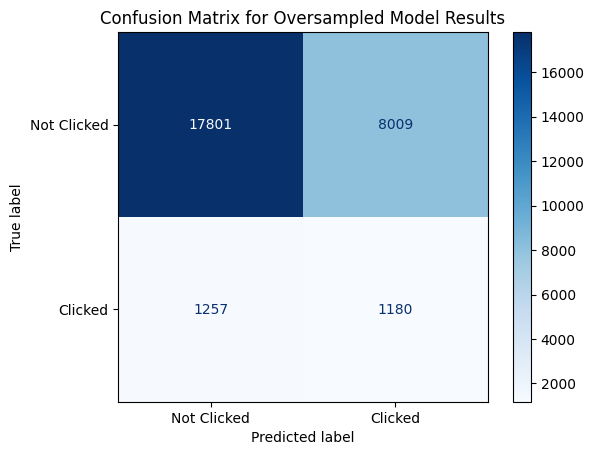

In [47]:
cm = confusion_matrix(y_class_val, y_pred_w2v_cat_bal, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Clicked', 'Clicked'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Oversampled Model Results")
plt.show()

The confusion matrix shows that while the classifier is able to identify a substantial number of clicked articles (1183), it also misclassified many not-clicked articles as clicked, resulting in a high number of false positives. This reflects the challenge of predicting rare engagement events, where increasing sensitivity to the minority class often leads to reduced overall precision.


### Plotting Regression Predictions vs. True Values

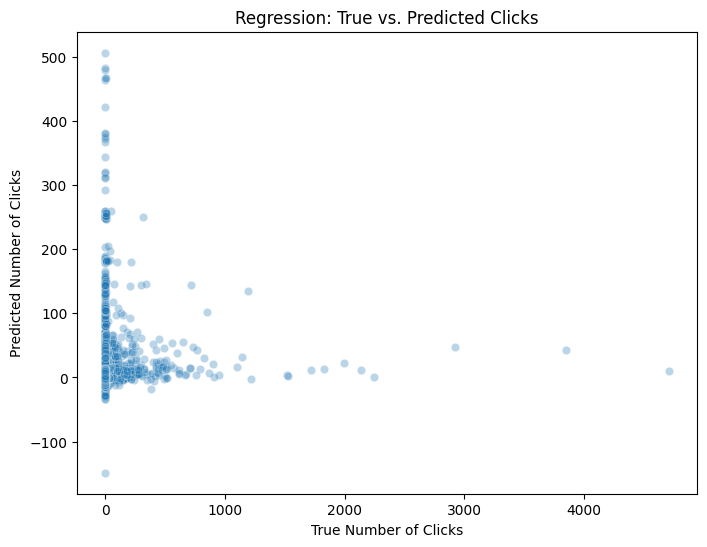

In [48]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_reg_val, y=y_reg_pred, alpha=0.3)
plt.xlabel("True Number of Clicks")
plt.ylabel("Predicted Number of Clicks")
plt.title("Regression: True vs. Predicted Clicks")
plt.show()

The scatter plot of true versus predicted click counts from the regression model highlights a strong bias toward lower values. Most predictions are clustered near zero, regardless of the true number of clicks, and the model fails to capture articles with unusually high engagement. This pattern underscores the difficulty of accurately modeling such highly imbalanced and skewed data.


## Feature Analysis

### Feature Importance: Logistic Regression (Classification)

Get Feature Names

In [49]:
# Remove stopwords when building TF-IDF matrix:
tfidf = TfidfVectorizer(max_features=200, stop_words='english')

# Fit (and transform) on text column
tfidf_matrix = tfidf.fit_transform(df['text'])

# For TF-IDF features
tfidf_feature_names = tfidf.get_feature_names_out()

# For categorical features (one-hot encoded)
cat_feature_names = ohe.get_feature_names_out(cat_features)

# For Word2Vec
w2v_feature_names = [f'w2v_{i}' for i in range(w2v_model.vector_size)]

Combine All Feature Names

In [50]:
feature_names = list(tfidf_feature_names) + list(cat_feature_names) + w2v_feature_names

Get Coefficients

Top 20 Logistic Regression Coefficients:
title_entities_label_O'Hare International Airport: 2.9660
title_entities_label_Matt Kuchar: 2.8298
title_entities_label_Michigan\u2013Ohio State football rivalry: 2.7561
title_entities_label_Union County: 2.6325
title_entities_label_Venice: 2.6258
title_entities_label_Mike Norvell: 2.4867
title_entities_label_Colorado Buffaloes: 2.4753
title_entities_label_Milky Way: 2.4586
title_entities_label_Violence Against Women Act: 2.4434
title_entities_label_Los Angeles Times: 2.4341
title_entities_label_Joe Burrow: 2.4334
title_entities_label_Bernard Tyson: 2.4095
title_entities_label_Marine City: 2.4021
title_entities_label_ISM Raceway: 2.3979
title_entities_label_Roman Polanski: 2.3911
subcategory_awardstyle: 2.3770
title_entities_label_Mookie Betts: 2.3706
title_entities_label_Hockey at the 2014 Commonwealth Games \u2013 Women's tournament: 2.3610
title_entities_label_Jeff Maggert: 2.3599
title_entities_label_Gus Malzahn: 2.3572


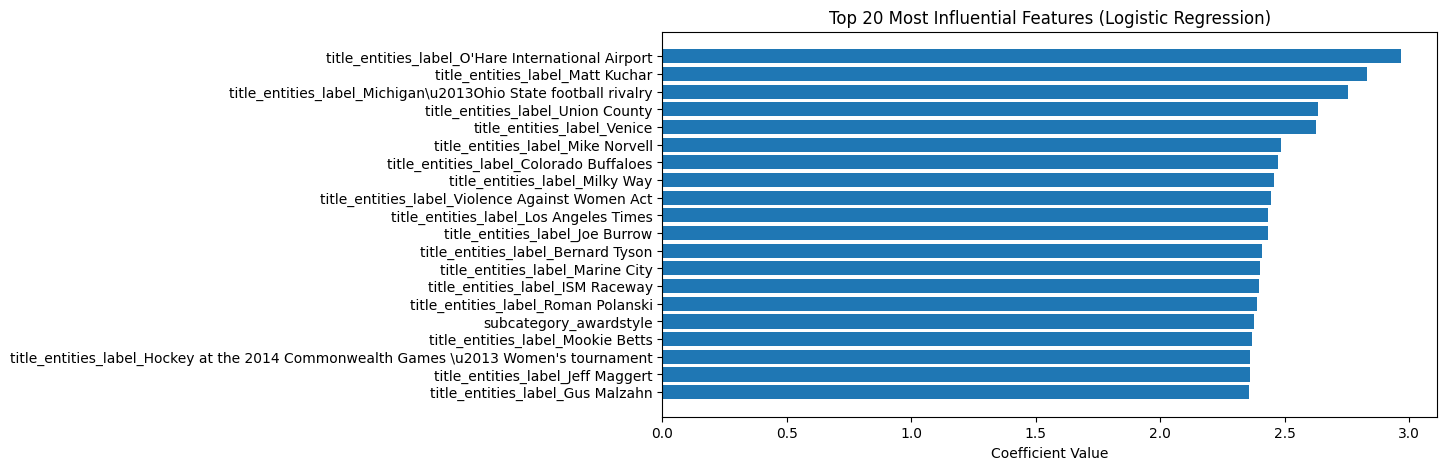

In [51]:
# For Logistic Regression (binary), coef_ shape is (1, n_features)
coefs = clf.coef_.flatten()

# Get absolute value and sort
top_idx_lr = np.argsort(np.abs(coefs))[::-1][:20]

print("Top 20 Logistic Regression Coefficients:")
for idx in top_idx_lr:
    print(f"{feature_names[idx]}: {coefs[idx]:.4f}")

plt.figure(figsize=(10, 5))
plt.barh([feature_names[i] for i in top_idx_lr[::-1]], [coefs[i] for i in top_idx_lr[::-1]])
plt.xlabel("Coefficient Value")
plt.title("Top 20 Most Influential Features (Logistic Regression)")
plt.show()

For logistic regression, the most influential features were specific named entities and one subcategory. The top positive coefficients were associated with entity labels such as “O'Hare International Airport,” “Matt Kuchar,” “Michigan–Ohio State football rivalry,” and “Union County.” Additional entities like “Venice,” “Mike Norvell,” “Colorado Buffaloes,” “Milky Way,” and “Violence Against Women Act” also ranked highly. The only non-entity in the top features was the subcategory “awardstyle,” suggesting that articles tagged with awards or style-related content may attract more clicks. This pattern indicates that stories mentioning prominent individuals, places, sporting events, and specific themes are more likely to receive user engagement.

Feature Importance: Random Forest

Top 20 Random Forest Importances:
shot: 0.0215
team: 0.0190
nfl: 0.0185
impeachment: 0.0174
area: 0.0157
november: 0.0141
family: 0.0139
california: 0.0120
white: 0.0117
injured: 0.0104
food: 0.0092
astros: 0.0090
injury: 0.0086
shooting: 0.0086
30: 0.0081
big: 0.0080
coach: 0.0075
college: 0.0073
ap: 0.0072
trump: 0.0071


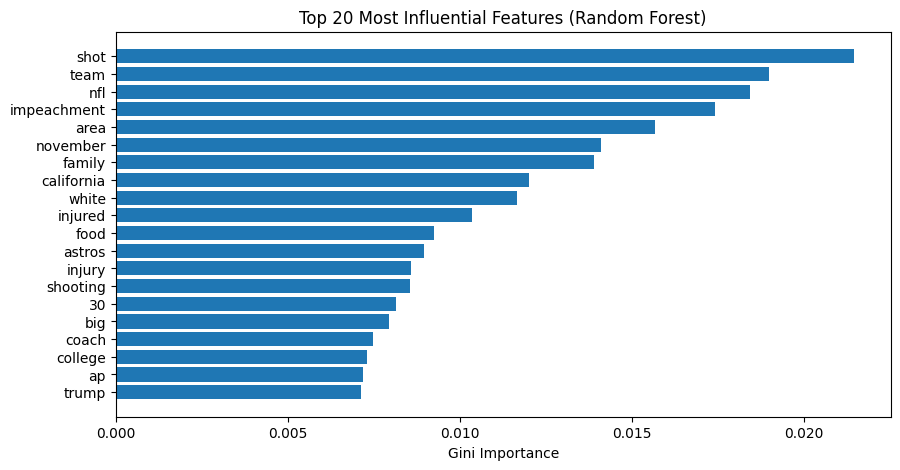

In [52]:
importances = rf_clf.feature_importances_
top_idx_rf = np.argsort(importances)[::-1][:20]
print("Top 20 Random Forest Importances:")
for idx in top_idx_rf:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

plt.figure(figsize=(10, 5))
plt.barh([feature_names[i] for i in top_idx_rf[::-1]], [importances[i] for i in top_idx_rf[::-1]])
plt.xlabel("Gini Importance")
plt.title("Top 20 Most Influential Features (Random Forest)")
plt.show()

For the random forest model, the most important features were primarily TF-IDF text features (keywords). The top-ranked words included “shot,” “team,” “nfl,” “impeachment,” “family,” and “area.” Other influential terms such as “november,” “white,” “injured,” “california,” “shooting,” and “food” also appeared in the top 20. This suggests that the model identifies newsworthy words tied to sports, major events, and societal issues as strong predictors of engagement, aligning with common trends in news consumption.

Note on Feature Importance Across Models:

We analyzed feature importance using both logistic regression coefficients and random forest feature importance. The features identified as most influential by each model do not fully overlap, which is expected. Logistic regression, being a linear model, highlights features with a direct, linear association to the target. In contrast, random forest is a non-linear, tree-based model that can capture complex interactions between variables, sometimes assigning higher importance to features that help split the data effectively even if their effect is not strictly linear. These differences provide complementary perspectives on which article attributes are linked to higher engagement.

## Learning Curve Analysis

Assess how model performance changes with increasing training data to understand data sufficiency and potential for improvement.

### Classification (Logistic Regression):

In [53]:
# Use full feature matrix and label
estimator = LogisticRegression(max_iter=1000)
train_sizes, train_scores, val_scores = learning_curve(
    estimator,
    X_train_w2v,             # full train set (unbalanced)
    y_class_train,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    random_state=42
)

/root/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/root/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/venv/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/root/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

In [54]:
# Compute mean and std
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

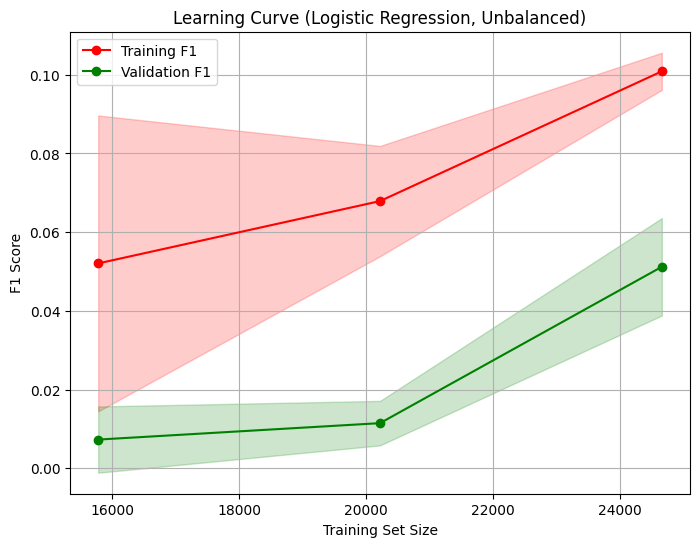

In [55]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training F1')
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.2, color='r')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation F1')
plt.fill_between(train_sizes, val_scores_mean-val_scores_std, val_scores_mean+val_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression, Unbalanced)')
plt.legend()
plt.grid()
plt.show()

Training and validation F1-scores are both quite low (max training ≈ 0.11, validation ≈ 0.05).

Both curves rise slightly with more data, but the validation F1 remains very low, and the gap between train and validation scores persists.

The standard deviation (shaded region) is wide for small data sizes, but narrows as sample size increases.

Interpretation:

- The low F1 scores for both training and validation indicate the model is struggling to distinguish the minority (“clicked”) class.

- The persistent gap and low validation performance suggest the issue is likely more model bias/feature limitations than overfitting.

- Adding more data may help a little, but feature engineering or rebalancing is more likely to improve results.

### Regression (Ridge):

In [56]:
estimator = Ridge()
train_sizes, train_scores, val_scores = learning_curve(
    estimator,
    X_train, y_reg_train,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    random_state=42
)

In [57]:
# Convert negative MSE to positive RMSE
train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
val_scores_mean = np.sqrt(-np.mean(val_scores, axis=1))
train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
val_scores_std = np.std(np.sqrt(-val_scores), axis=1)

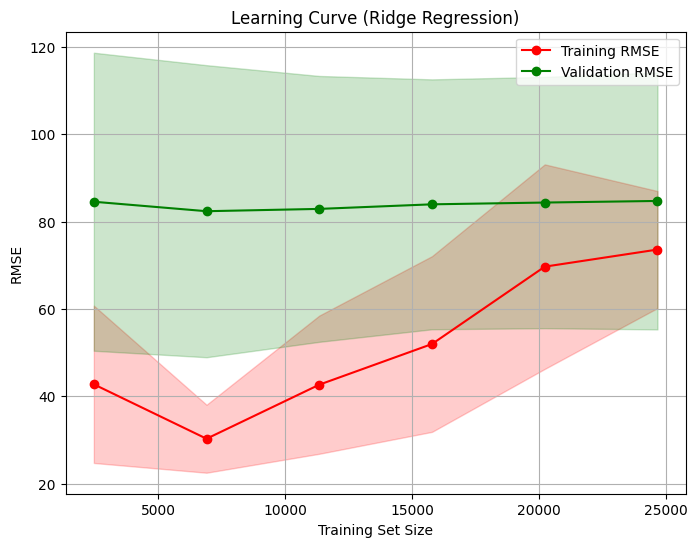

In [58]:
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training RMSE')
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.2, color='r')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation RMSE')
plt.fill_between(train_sizes, val_scores_mean-val_scores_std, val_scores_mean+val_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (Ridge Regression)')
plt.legend()
plt.grid()
plt.show()

Training RMSE increases with more data, as expected.

Validation RMSE stays nearly flat (≈ 83–86) regardless of training size, with wide confidence intervals.

There’s a substantial gap between train and validation RMSE, especially as training set grows.

Interpretation:

- The validation RMSE does not improve as more data is added, suggesting that simply increasing training data will not substantially improve regression performance.

- The consistent gap between training and validation RMSE points to either a limitation in the current feature set or an inherent challenge in the prediction task (the target is hard to predict from the features).

- Like the classification results, further improvements are more likely to come from new features, better models, or different targets, rather than just more training data.

## Sensitivity analysis 

Evaluate how model performance varies with different regularization strengths or other hyperparameters.

### Hyperparameter Sensitivity (Logistic Regression Regularization)

Test how model performance changes as we vary the regularization strength (C) in logistic regression.

In [59]:
C_values = [0.01, 0.1, 1, 10, 100]
train_f1, val_f1 = [], []

for C in C_values:
    clf = LogisticRegression(max_iter=1000, C=C)
    clf.fit(X_train, y_class_train)
    train_pred = clf.predict(X_train)
    val_pred = clf.predict(X_val)
    # Specify pos_label due to highly imbalanced data:
    train_f1.append(f1_score(y_class_train, train_pred, pos_label=1))
    val_f1.append(f1_score(y_class_val, val_pred, pos_label=1))

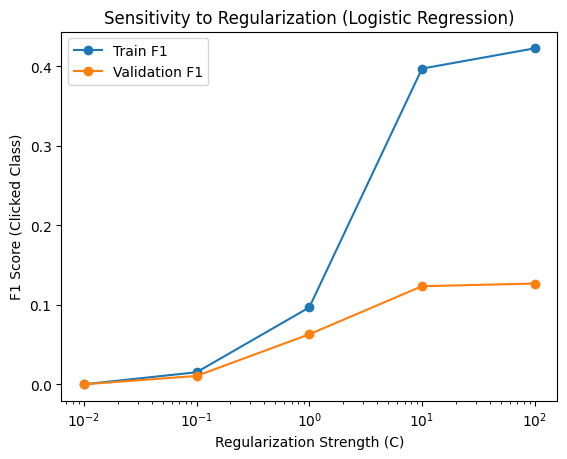

In [60]:
plt.plot(C_values, train_f1, 'o-', label='Train F1')
plt.plot(C_values, val_f1, 'o-', label='Validation F1')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('F1 Score (Clicked Class)')
plt.title('Sensitivity to Regularization (Logistic Regression)')
plt.legend()
plt.show()

## Error (failure) analysis

Examine misclassified and high-error cases to better understand model limitations and suggest targeted improvements

Find Examples of Misclassifications (Classification)

In [61]:
# Get misclassified indices for validation set
misclassified_fp = (y_class_val == 0) & (y_pred_w2v_cat_bal == 1)  # False Positives
misclassified_fn = (y_class_val == 1) & (y_pred_w2v_cat_bal == 0)  # False Negatives

# Show a few false positives and false negatives
print("Sample False Positives (predicted clicked, actually not clicked):")
display(df[val_mask][misclassified_fp].sample(3)[['title', 'text', 'category', 'subcategory', 'title_entities_label']])

print("\nSample False Negatives (missed real clicks):")
display(df[val_mask][misclassified_fn].sample(3)[['title', 'text', 'category', 'subcategory', 'title_entities_label']])

Sample False Positives (predicted clicked, actually not clicked):


,title,text,category,subcategory,title_entities_label
29198,Outer Banks storms unearth old shipwreck from ...,Outer Banks storms unearth old shipwreck from ...,news,newsus,Outer Banks
26632,Doctoral student poses in skirt made out of re...,Doctoral student poses in skirt made out of re...,video,lifestyle,
53259,The Ultimate Holiday Survival Guide For New Co...,The Ultimate Holiday Survival Guide For New Co...,lifestyle,lifestylefamilyandrelationships,



Sample False Negatives (missed real clicks):


,title,text,category,subcategory,title_entities_label
34259,Is Miss USA Ready for Its First Woman In a Whe...,Is Miss USA Ready for Its First Woman In a Whe...,lifestyle,lifestylebuzz,Miss USA
64590,Planned Parenthood Wins Lawsuit Against Anti-A...,Planned Parenthood Wins Lawsuit Against Anti-A...,news,newsus,Planned Parenthood
63470,The next two weeks could go a long way in deci...,The next two weeks could go a long way in deci...,sports,football_nfl,NFC East


In [62]:
# Get DataFrame of all false positives in the validation set
fp_df = df[val_mask][misclassified_fp]

# Show counts for categories
fp_categories = fp_df['category'].value_counts()
print("False Positive Category Distribution:")
print(fp_categories)

# Show counts for subcategories (optional)
fp_subcategories = fp_df['subcategory'].value_counts()
print("\nFalse Positive Subcategory Distribution:")
print(fp_subcategories)

False Positive Category Distribution:
category
news             2752
sports           1971
finance           605
foodanddrink      496
health            452
lifestyle         367
weather           331
travel            241
video             238
autos             216
tv                119
entertainment      98
music              72
movies             49
kids                2
games               0
middleeast          0
northamerica        0
Name: count, dtype: int64

False Positive Subcategory Distribution:
subcategory
football_nfl              1101
newsus                     763
newscrime                  629
newspolitics               535
newsworld                  442
                          ... 
ustravel                     0
movies-awards                0
mmaufc                       0
middleeast-top-stories       0
newsnational                 0
Name: count, Length: 270, dtype: int64


/tmp/ipykernel_94/750083450.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_94/750083450.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


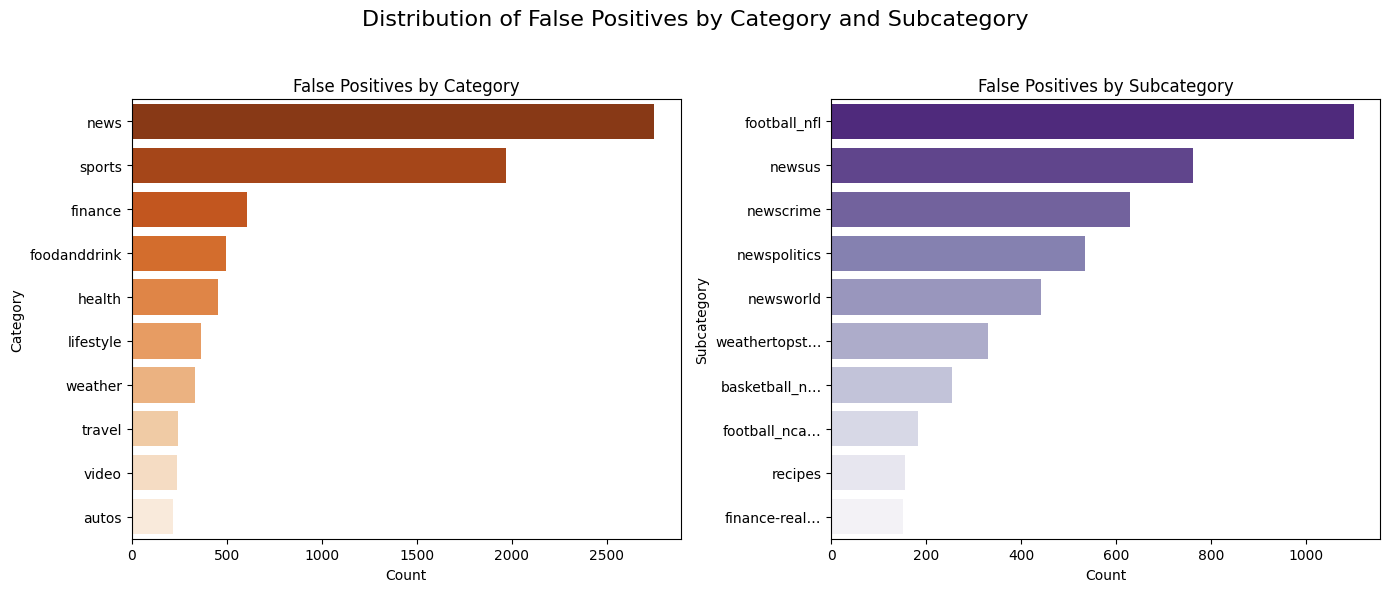

In [63]:
# Get DataFrame of all false positives in the validation set
fp_df = df[val_mask][misclassified_fp]

# Show counts for categories and subcategories, sorted in descending order
N = 10
fp_categories = fp_df['category'].value_counts().sort_values(ascending=False).head(N)
fp_subcategories = fp_df['subcategory'].value_counts().sort_values(ascending=False).head(N)

# Shorten subcategory names for display
short_fp_subcat_labels = [sc[:12] + '…' if len(sc) > 12 else sc for sc in fp_subcategories.index]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Explicitly control order for categories
sns.barplot(
    y=fp_categories.index,
    x=fp_categories.values,
    ax=axes[0],
    palette='Oranges_r',
    order=fp_categories.index.tolist()
)
axes[0].set_title("False Positives by Category")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Category")

sns.barplot(
    y=short_fp_subcat_labels,
    x=fp_subcategories.values,
    ax=axes[1],
    palette='Purples_r'
)
axes[1].set_title("False Positives by Subcategory")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Subcategory")

plt.suptitle("Distribution of False Positives by Category and Subcategory", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [64]:
# Get DataFrame of all false negatives in the validation set
fn_df = df[val_mask][misclassified_fn]

# Show counts for categories
fn_categories = fn_df['category'].value_counts()
print("False Negative Category Distribution:")
print(fn_categories)

# Show counts for subcategories (optional)
fn_subcategories = fn_df['subcategory'].value_counts()
print("\nFalse Negative Subcategory Distribution:")
print(fn_subcategories)

False Negative Category Distribution:
category
news             336
sports           238
lifestyle         89
travel            83
finance           76
foodanddrink      74
health            73
autos             73
video             53
tv                42
movies            36
music             31
weather           27
entertainment     26
middleeast         0
kids               0
games              0
northamerica       0
Name: count, dtype: int64

False Negative Subcategory Distribution:
subcategory
newsus                 182
football_nfl            78
newstrends              46
newspolitics            40
lifestylebuzz           40
                      ... 
autospassenger           0
autosresearchguides      0
autosreview              0
autossema                0
autostokyo               0
Name: count, Length: 270, dtype: int64


/tmp/ipykernel_94/2231412128.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_94/2231412128.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


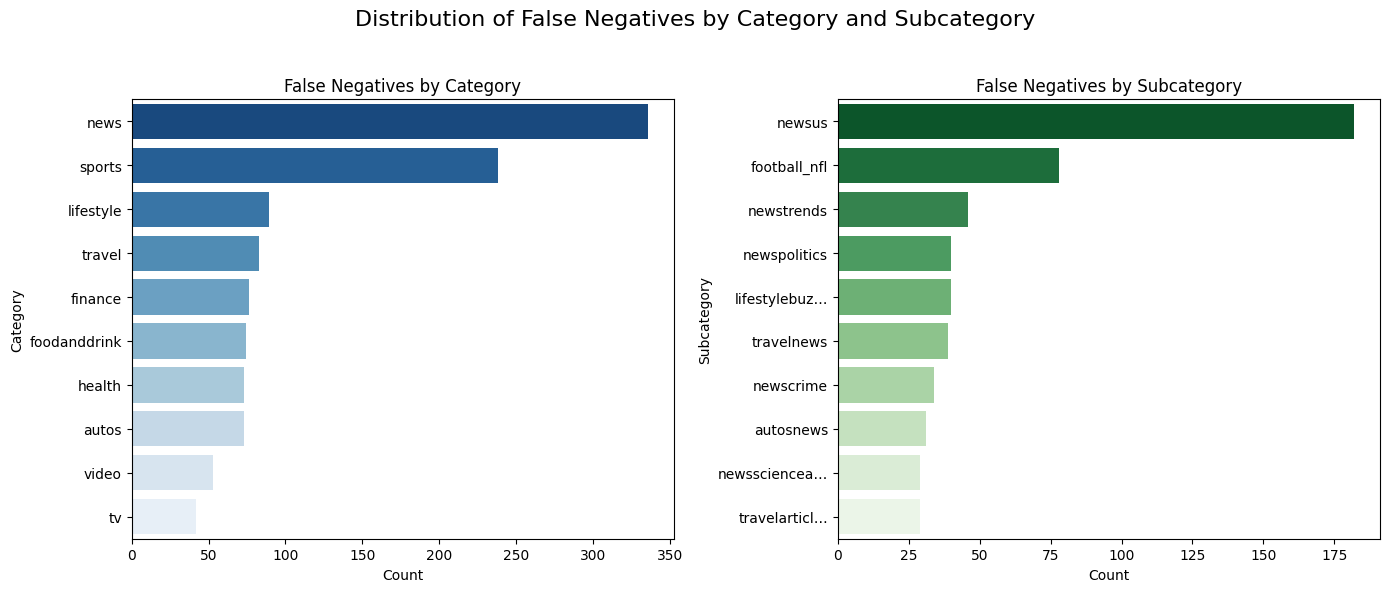

In [65]:
# Select top N for display, sorted in descending order
N = 10
top_fn_categories = fn_categories.sort_values(ascending=False).head(N)
top_fn_subcategories = fn_subcategories.sort_values(ascending=False).head(N)
short_subcat_labels = [sc[:12] + '…' if len(sc) > 12 else sc for sc in top_fn_subcategories.index]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Explicitly control order for categories
sns.barplot(
    y=top_fn_categories.index,
    x=top_fn_categories.values,
    ax=axes[0],
    palette='Blues_r',
    order=top_fn_categories.index.tolist()  # ensure ordering by count
)
axes[0].set_title("False Negatives by Category")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Category")

sns.barplot(
    y=short_subcat_labels,
    x=top_fn_subcategories.values,
    ax=axes[1],
    palette='Greens_r'
)
axes[1].set_title("False Negatives by Subcategory")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Subcategory")

plt.suptitle("Distribution of False Negatives by Category and Subcategory", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Analyze the Most Common Type of Error

In [66]:
print("Validation set label distribution:", Counter(y_class_val))
print("Predicted label distribution:", Counter(y_pred_w2v_cat_bal))

print(f"False Positives: {misclassified_fp.sum()} / {len(y_class_val)}")
print(f"False Negatives: {misclassified_fn.sum()} / {len(y_class_val)}")

Validation set label distribution: Counter({0: 25810, 1: 2437})
Predicted label distribution: Counter({0: 19058, 1: 9189})
False Positives: 8009 / 28247
False Negatives: 1257 / 28247


Examine Feature Contributions for One Error

In [67]:
# Pick a sample false negative
fn_idx = np.where(misclassified_fn)[0][0]  # Pick the first false negative
sample_features = X_val_w2v[fn_idx].toarray().flatten()
# Get top positive/negative features for this article
feature_contributions = sample_features * clf_w2v_cat_bal.coef_.flatten()
top_idx = np.argsort(np.abs(feature_contributions))[::-1][:10]
print("Top contributing features for this false negative:")
for idx in top_idx:
    print(f"{feature_names[idx]}: {feature_contributions[idx]:.2f}")

Top contributing features for this false negative:
got: -0.45
subcategory_football_nfl: -0.34
title_entities_label_Jamie Benn: -0.29
30: 0.21
ap: 0.20
2019: -0.15
20: 0.12
title_entities_label_Xiaomi: 0.12
best: 0.12
12: -0.11


Analyze Regression Errors

In [68]:
# Get errors for regression predictions
errors = np.abs(y_reg_val - y_reg_pred)
largest_error_idx = np.argsort(errors)[-3:]

print("Sample largest regression errors:")
display(df[val_mask].iloc[largest_error_idx][['title', 'text', 'category', 'subcategory', 'title_entities_label']])
print("True clicks:", y_reg_val.iloc[largest_error_idx].values)
print("Predicted clicks:", y_reg_pred[largest_error_idx])

Sample largest regression errors:


,title,text,category,subcategory,title_entities_label
40748,This was uglier than a brawl. And Myles Garret...,This was uglier than a brawl. And Myles Garret...,sports,football_nfl,Myles Garrett
31393,30 Best Black Friday Deals from Costco,30 Best Black Friday Deals from Costco Costco ...,lifestyle,shop-holidays,Costco
38549,South Carolina teen gets life in prison for de...,South Carolina teen gets life in prison for de...,news,newsus,South Carolina


True clicks: [2922 3846 4711]
Predicted clicks: [48.0608425  42.47707373  9.80321769]


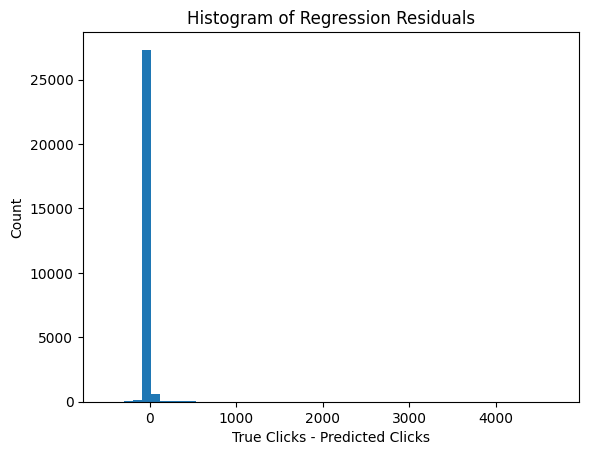

RMSE for high-engagement articles: 61.65793183429324


In [69]:
# Histogram of residuals (prediction error)
residuals = y_reg_val - y_reg_pred
plt.hist(residuals, bins=50)
plt.title('Histogram of Regression Residuals')
plt.xlabel('True Clicks - Predicted Clicks')
plt.ylabel('Count')
plt.show()

# Analyze top 20% highest true clicks
threshold = np.percentile(y_reg_val, 80)
high_clicks_mask = y_reg_val >= threshold
print("RMSE for high-engagement articles:",
      np.sqrt(np.mean((y_reg_val[high_clicks_mask] - y_reg_pred[high_clicks_mask])**2)))

Suggest What’s Missing/Next Steps

Next Steps:
For each type of failure, we can experiment with additional features (e.g., user or time signals), use more complex models, or apply interpretability tools like SHAP to better understand and reduce errors.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c8be285d-9d64-40ba-873b-a353fe8ae087' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>